# Image Classification Project

## Import

In [7]:
import warnings

import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

# Import Packages
import tensorflow as tf
from tensorflow.keras.applications import VGG16 
from tensorflow.python.client import device_lib

warnings.filterwarnings('ignore')

In [8]:
print('GPU', 'Available (YESSSSSS!!!!!!)' if tf.config.list_physical_devices('GPU') else 'Not available :(')
print(tf.config.list_physical_devices())

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


GPU Not available :(
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
['/device:CPU:0']


In [322]:
DATA_DIR = '../data/raw/'
NUM_IMAGES = 25000
IMG_SIZE = 224
CHANNELS = 3
LOGDIR = os.path.join(
    r'..\data\logs',
    datetime.datetime.now().strftime("Y%m%d-%H%M%S")
)
NUM_EPOCHS = 10

In [323]:
print(LOGDIR)

..\data\logs\Y0303-161640


In [324]:
def df_with_labels(directory = DATA_DIR, operation = 'train'):
    labels = []
    directory_to_list = directory + '/' + operation

    directory_files = os.listdir(
        directory_to_list
    )

    routes = []
    for image in directory_files:
        routes.append(DATA_DIR + operation + '/' + image)

    for file in directory_files:
        if 'dog' in file:
            labels.append('dog')
        if 'cat' in file:
            labels.append('cat')

    df = pd.DataFrame(
        {
            'filename': routes,
            'animal': labels
        }
    )

    dog_images = [
        file 
        for file in directory_files 
        if file.startswith('dog')
    ]

    not_dogs = [
        file 
        for file in directory_files 
        if not file.startswith('dog')
    ]

    return {
        'files': directory_files,
        'dog_files': dog_images,
        'not_dogs': not_dogs
    }, df

In [325]:
def plots(files, operation = 'train/', directory = DATA_DIR):
    plt.figure(figsize=(12, 8))

    for i in range(min(len(files), 12)):  # Display up to 12 images
        image_path = directory + operation + files[i]
        image = Image.open(image_path)
        plt.subplot(4, 3, i + 1)
        plt.imshow(image)
        plt.title(files[i])
        plt.axis('off')

    # Adjust Layout
    plt.tight_layout()

    # Show the pictures
    plt.show()

In [326]:
def preprocess_image(img_path, img_size = IMG_SIZE, channs = CHANNELS):
    img = tf.io.read_file(img_path)

    img = tf.image.decode_jpeg(
        img,
        channels = channs
    )

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(
        img,
        size = [img_size, img_size]
    )

    return img

In [327]:
def get_image_label(img_path, label):
    img = preprocess_image(img_path)

    return img, label

In [328]:
def create_data_batches(x, y=None, batch_size = 32, valid_data=False, test_data=False):
    # If test then no labels
    if test_data:
        print('\tCreating test batches...')

        data = tf.data.Dataset.from_tensor_slices(
            (tf.constant(x))
        )

        data_batch = data.map(
            preprocess_image
        ).batch(
            batch_size
        )

        print('\tCreation... Done.')

    elif valid_data:
        print('\tCreating validation batches...')

        data = tf.data.Dataset.from_tensor_slices(
            (
                tf.constant(x),
                tf.constant(y)
            )
        )

        data_batch = data.map(
            get_image_label
        ).batch(
            batch_size
        )

        print('\tCreation... Done.')
    
    else:
        print('\tCreating validation batches...')

        data = tf.data.Dataset.from_tensor_slices(
            (
                tf.constant(x),
                tf.constant(y)
            )
        )

        data_batch = data.map(
            get_image_label
        ).batch(
            batch_size
        )

        print('\tCreation... Done.')

    return data_batch

In [329]:
data_fltd, dataset = df_with_labels()
data_fltd['not_dogs']

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg',
 'cat.10008.jpg',
 'cat.10009.jpg',
 'cat.1001.jpg',
 'cat.10010.jpg',
 'cat.10011.jpg',
 'cat.10012.jpg',
 'cat.10013.jpg',
 'cat.10014.jpg',
 'cat.10015.jpg',
 'cat.10016.jpg',
 'cat.10017.jpg',
 'cat.10018.jpg',
 'cat.10019.jpg',
 'cat.1002.jpg',
 'cat.10020.jpg',
 'cat.10021.jpg',
 'cat.10022.jpg',
 'cat.10023.jpg',
 'cat.10024.jpg',
 'cat.10025.jpg',
 'cat.10026.jpg',
 'cat.10027.jpg',
 'cat.10028.jpg',
 'cat.10029.jpg',
 'cat.1003.jpg',
 'cat.10030.jpg',
 'cat.10031.jpg',
 'cat.10032.jpg',
 'cat.10033.jpg',
 'cat.10034.jpg',
 'cat.10035.jpg',
 'cat.10036.jpg',
 'cat.10037.jpg',
 'cat.10038.jpg',
 'cat.10039.jpg',
 'cat.1004.jpg',
 'cat.10040.jpg',
 'cat.10041.jpg',
 'cat.10042.jpg',
 'cat.10043.jpg',
 'cat.10044.jpg',
 'cat.10045.jpg',
 'cat.10046.jpg',
 'cat.1004

In [330]:
dataset.tail()

,filename,animal
24995,../data/raw/train/dog.9995.jpg,dog
24996,../data/raw/train/dog.9996.jpg,dog
24997,../data/raw/train/dog.9997.jpg,dog
24998,../data/raw/train/dog.9998.jpg,dog
24999,../data/raw/train/dog.9999.jpg,dog


In [331]:
dataset['label'] = dataset['animal'].map({'cat': 0,'dog': 1})
dataset.head()

,filename,animal,label
0,../data/raw/train/cat.0.jpg,cat,0
1,../data/raw/train/cat.1.jpg,cat,0
2,../data/raw/train/cat.10.jpg,cat,0
3,../data/raw/train/cat.100.jpg,cat,0
4,../data/raw/train/cat.1000.jpg,cat,0


In [332]:
dataset.tail()

,filename,animal,label
24995,../data/raw/train/dog.9995.jpg,dog,1
24996,../data/raw/train/dog.9996.jpg,dog,1
24997,../data/raw/train/dog.9997.jpg,dog,1
24998,../data/raw/train/dog.9998.jpg,dog,1
24999,../data/raw/train/dog.9999.jpg,dog,1


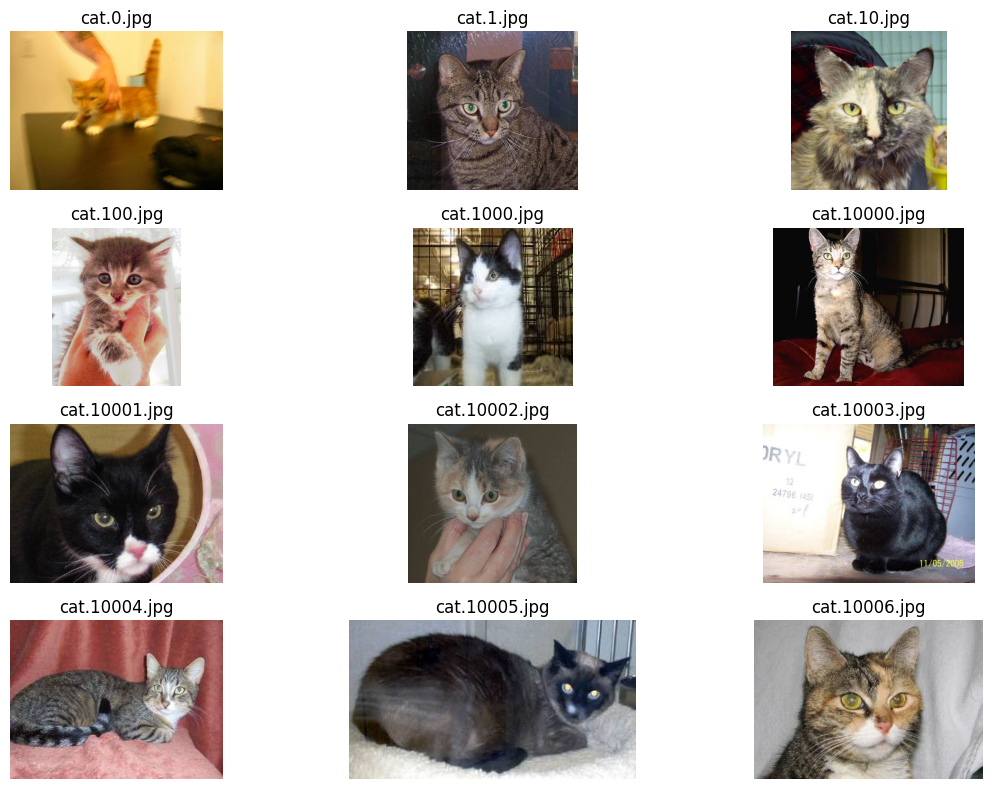

In [333]:
plots(data_fltd['files'])

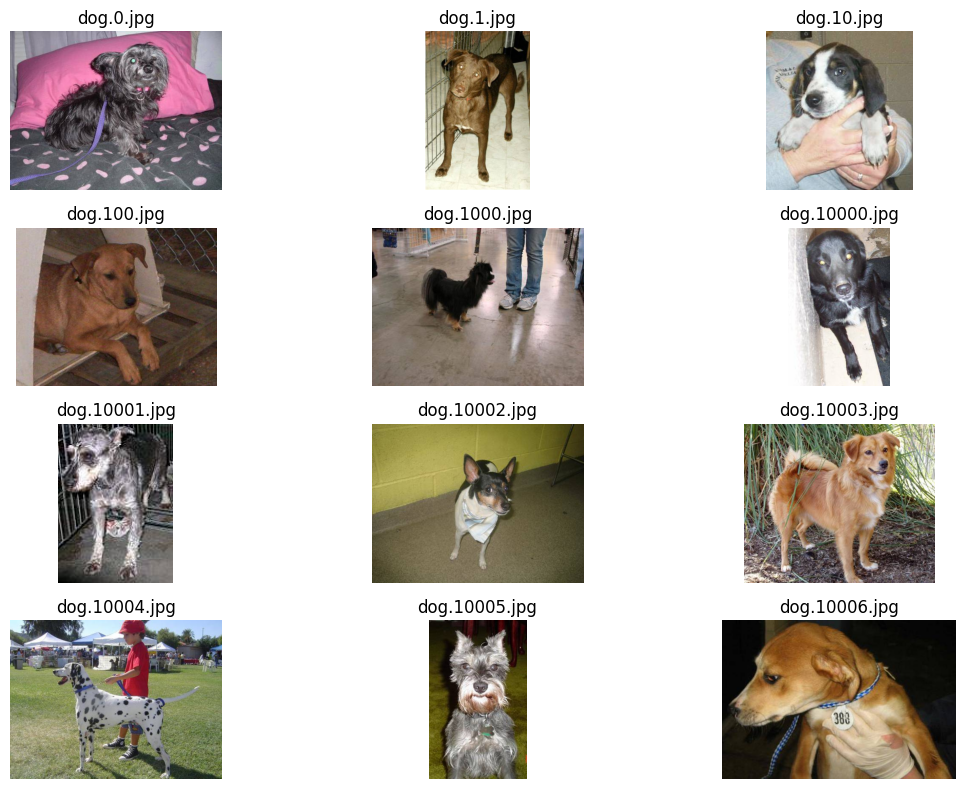

In [334]:
plots(data_fltd['dog_files'])

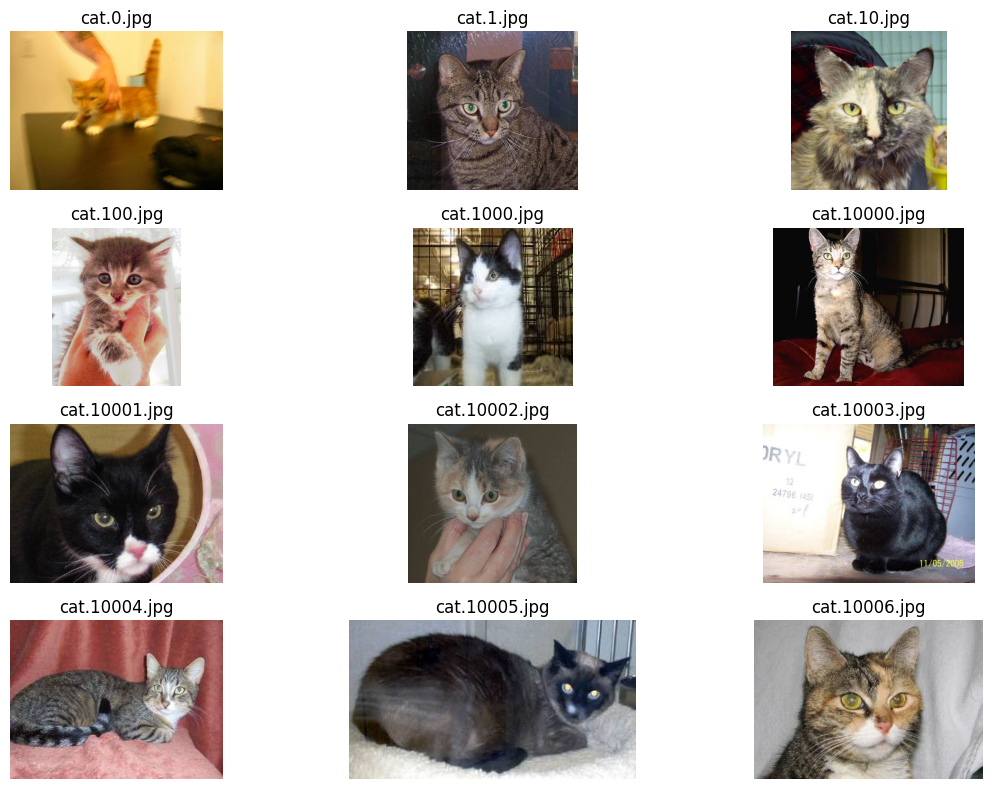

In [335]:
plots(data_fltd['not_dogs'])

### Create Validation Set

In [336]:
x = dataset['filename']
y = dataset['label']

In [337]:
x_train, x_val, y_train, y_val = train_test_split(
    x[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size = 0.2,
    random_state = 42
)

len(x_train), len(y_train), len(x_val), len(y_val)

(20000, 20000, 5000, 5000)

In [338]:
x_train.head()

23311     ../data/raw/train/dog.8479.jpg
23623      ../data/raw/train/dog.876.jpg
1020     ../data/raw/train/cat.10915.jpg
12645    ../data/raw/train/dog.10127.jpg
1533     ../data/raw/train/cat.11377.jpg
Name: filename, dtype: object

In [339]:
y_train.head()

23311    1
23623    1
1020     0
12645    1
1533     0
Name: label, dtype: int64

In [340]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

	Creating validation batches...
	Creation... Done.
	Creating validation batches...
	Creation... Done.


In [341]:
BATCH = None
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, CHANNELS]
OUTPUT_SHAPE = len(dataset['label'].unique())

def build_base_model(freeze, input_shape = INPUT_SHAPE):
    # Load the VGG16 model, pretrained on ImageNet
    base_model = VGG16(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = freeze

    return base_model

def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, freeze_status = False, learn_rate = 0.001):
    base_model = build_base_model(freeze = freeze_status)

    # Create a custom model on top of the pretrained VGG16 model
    x = tf.keras.layers.Flatten()(base_model.output)  # Flatten the output of the base model
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a fully connected layer with 512 units and ReLU activation
    x = tf.keras.layers.Dropout(0.5)(x)  # Apply dropout regularization to prevent overfitting
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Add a final output layer with sigmoid activation for binary classification
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)  # Define the input and output of the custom model

    # Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate = learn_rate
        ), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )

    model.build(
        input_shape
    )

    return model

In [342]:
model = create_model()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [343]:
%load_ext tensorboard

def create_tensorboard_callback():
    return tf.keras.callbacks.TensorBoard(log_dir = LOGDIR)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [344]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3
)

In [345]:
freeze = True
learn = 0.0001
def train_model():
    model = create_model()

    tensorboard = create_tensorboard_callback()

    model.fit(
        x = train_data,
        epochs = NUM_EPOCHS,
        validation_data = val_data,
        validation_freq = 1,
        callbacks = [tensorboard, early_stopping]
    )

    return model

In [346]:
model = train_model()

Epoch 1/10
625/625 [==============================] - 1544s 2s/step - loss: 0.3512 - accuracy: 0.8830 - val_loss: 0.1911 - val_accuracy: 0.9194
Epoch 2/10
625/625 [==============================] - 1472s 2s/step - loss: 0.2012 - accuracy: 0.9150 - val_loss: 0.1753 - val_accuracy: 0.9270
Epoch 3/10
625/625 [==============================] - 1471s 2s/step - loss: 0.1726 - accuracy: 0.9272 - val_loss: 0.1810 - val_accuracy: 0.9272
Epoch 4/10
278/625 [============>.................] - ETA: 11:22 - loss: 0.1599 - accuracy: 0.9326

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir ../data/logs

Reusing TensorBoard on port 6006 (pid 20996), started 0:05:26 ago. (Use '!kill 20996' to kill it.)

In [ ]:
model_opt = train_model(
    freeze = True
    learn = 0.0001
)